# Predicting If it Rains Tomorrow in Australia

### Rich Caputo

In this project, we will be analyzing rainfall weather in Australia and building a binary classification algorithm to predict whether or not it will rain tomorrow. This dataset is relatively clean but will require some feature engineering to extract the full essense of the data. Our hope is to build a robust and easy to use model using sklearn pipelines. All data transformations will be fit to the training set to avoid data snooping.

In [2]:
# Get essential packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

# Sci-kit Learn Essentials
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

### Loading and Exploring Data

In [2]:
# Need to drop RISK_MM due to data leakage
# Set date to index and sort
df = pd.read_csv('weatherAUS.csv', parse_dates=['Date'], index_col=0).drop('RISK_MM', axis=1).sort_index()
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142193 entries, 2007-11-01 to 2017-06-25
Data columns (total 22 columns):
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null object
RainTomorrow     1421

As we can see, there is a fair bit of null entries in our data. We will need to impute these somehow. Let's examine how long our data set spans.

In [4]:
df.index.min(), df.index.max()

(Timestamp('2007-11-01 00:00:00'), Timestamp('2017-06-25 00:00:00'))

In [5]:
df.index.max() - df.index.min()

Timedelta('3524 days 00:00:00')

That's strange: it seems that although we have 3524 days of data, we have 142193 total entries in our data. Let's examine this.

In [6]:
df.index.value_counts()

2013-12-22    49
2014-02-27    49
2016-08-21    49
2013-07-02    49
2017-05-05    49
2013-10-06    49
2013-05-13    49
2014-07-14    49
2017-05-28    49
2014-04-14    49
2014-12-10    49
2017-05-13    49
2013-09-11    49
2014-05-25    49
2013-07-01    49
2014-07-15    49
2016-05-15    49
2016-06-30    49
2013-12-12    49
2013-05-12    49
2013-04-01    49
2013-03-19    49
2017-01-12    49
2013-06-12    49
2013-12-24    49
2014-10-19    49
2013-07-03    49
2013-10-23    49
2014-05-26    49
2017-05-15    49
              ..
2008-01-16     1
2007-11-06     1
2007-12-25     1
2008-01-13     1
2007-11-05     1
2008-01-02     1
2007-11-02     1
2008-01-31     1
2007-11-11     1
2008-01-29     1
2007-11-15     1
2007-12-17     1
2008-01-06     1
2008-01-03     1
2008-01-04     1
2007-12-08     1
2008-01-28     1
2008-01-14     1
2007-12-07     1
2008-01-09     1
2007-12-24     1
2007-11-18     1
2007-12-06     1
2007-12-04     1
2007-11-08     1
2007-11-14     1
2007-11-23     1
2007-11-13    

In [7]:
df.loc['2013-12-22']

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-22,Melbourne,16.6,28.4,0.0,1.6,0.0,NNW,54.0,NE,NNW,...,87.0,57.0,1008.0,1005.4,NaN,NaN,18.9,26.0,No,Yes
2013-12-22,CoffsHarbour,19.5,28.6,0.0,NaN,NaN,NNE,63.0,N,NE,...,63.0,55.0,1016.7,1013.2,1.0,5.0,25.6,26.6,No,No
2013-12-22,NorahHead,21.1,26.5,0.0,NaN,NaN,NNE,46.0,NNE,N,...,87.0,81.0,1013.0,1009.1,NaN,NaN,22.4,23.6,No,No
2013-12-22,Moree,24.2,37.7,0.0,15.8,12.6,NNE,52.0,NNE,NW,...,46.0,17.0,1015.6,1011.2,6.0,5.0,27.2,35.9,No,No
2013-12-22,Albany,12.1,21.5,0.0,6.2,12.2,NaN,NaN,NE,ESE,...,51.0,56.0,1021.5,1017.9,2.0,0.0,19.0,19.9,No,No
2013-12-22,Richmond,19.7,37.1,0.0,NaN,NaN,NNE,33.0,NNE,N,...,63.0,21.0,1012.0,1007.2,NaN,NaN,26.4,35.6,No,No
2013-12-22,Brisbane,19.0,30.0,0.0,9.4,12.7,ENE,26.0,NNW,ENE,...,54.0,52.0,1017.6,1014.9,2.0,2.0,26.2,28.4,No,No
2013-12-22,Cobar,25.8,42.5,0.0,18.8,NaN,NE,52.0,NNW,NNE,...,13.0,6.0,1010.3,1006.5,6.0,6.0,33.2,41.0,No,No
2013-12-22,Williamtown,21.0,36.0,0.0,29.8,NaN,NE,35.0,NNW,NE,...,72.0,41.0,1014.1,1009.7,6.0,7.0,25.1,34.7,No,No


Aha: Although we have entries with the same date occasionally, this is due to data representing different locations in Australia. Let's examine temperatures in different regions!

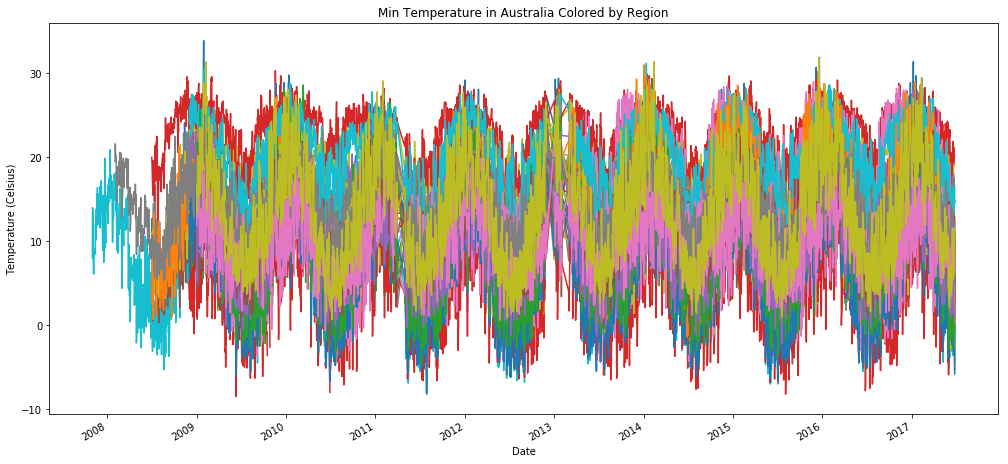

In [8]:
df.groupby('Location')['MinTemp'].plot(figsize=(17, 8))
plt.title('Min Temperature in Australia Colored by Region')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.show()

Although we don't have space to label the legend, this plot gives us an overall sense of how temperature fluctuates over time in Australia. Perhaps a good way to capture this seasonality would be to add a Month column to the data (we will do this during the modeling phase).

Let's now examine how our features correlate.


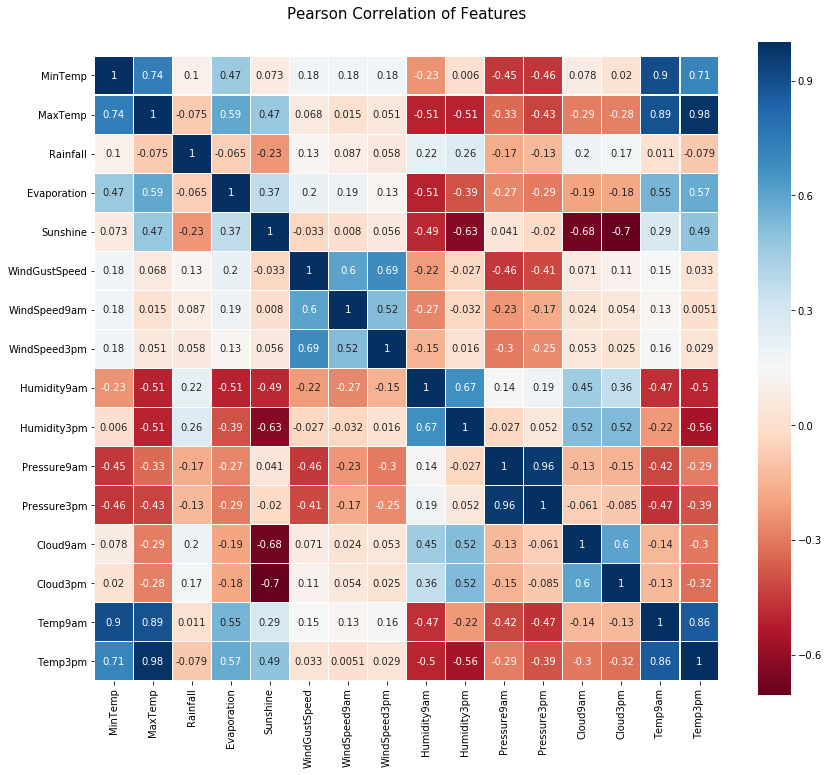

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

There are some obvious correlations here, such as max/min temp vs. temp9am and temp3pm. Also notice how cloud and sunshine variables are negatively correlated. No suprise there. Interestingly, it seems temp and humidity are inversely correlated. So is sunshine and humidity. Also, temperature and pressure are slightly negatively correlated. Since the models we are using are non-linear, we don't have to worry to much about removing co-linear features as our models will capture these relationships.

An interesting thing to do would be to visualize how this data varies by location in more ways than just temperature. To do this, we will perform PCA to project the data into 2-dimmensions and visualize data based on location. For fitting purposes, we will impute NaN values using a custom DataFrameImputer, which will fill string NaN's to the most frequent value while gitting numeric NaN's to the current mean. This is easy for now since we are using the whole dataset, but will require some modifications for model fitting with a train and test set.

In [10]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    
    def fit(self, X, y=None):
        """ Imputes categoricals with 'O' and numericals with the mean. """
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        """ Executes transformation from fit. """
        return X.fillna(self.fill)

    
df_nl = df.drop('Location', axis=1)
cat_cols = list(df_nl.select_dtypes(include=object, exclude=None).columns)

pipe = make_pipeline(
    DataFrameImputer(),
    StandardScaler(),
    PCA(n_components=3)   
)

X_red = pipe.fit_transform(pd.get_dummies(df_nl))

In [11]:
X_red

array([[-1.29669142,  0.41860213, -0.98491055],
       [-0.20675317,  2.09792203,  0.80569179],
       [-2.64956492,  4.21157924, -0.6137139 ],
       ...,
       [-0.95288458, -1.59644998, -2.02478657],
       [-1.16834589, -2.44346069,  0.59163724],
       [ 0.0502009 , -1.18762505, -2.90377892]])

Text(0.5, 1.0, '2D PCA Projection of Data Colored by Location')

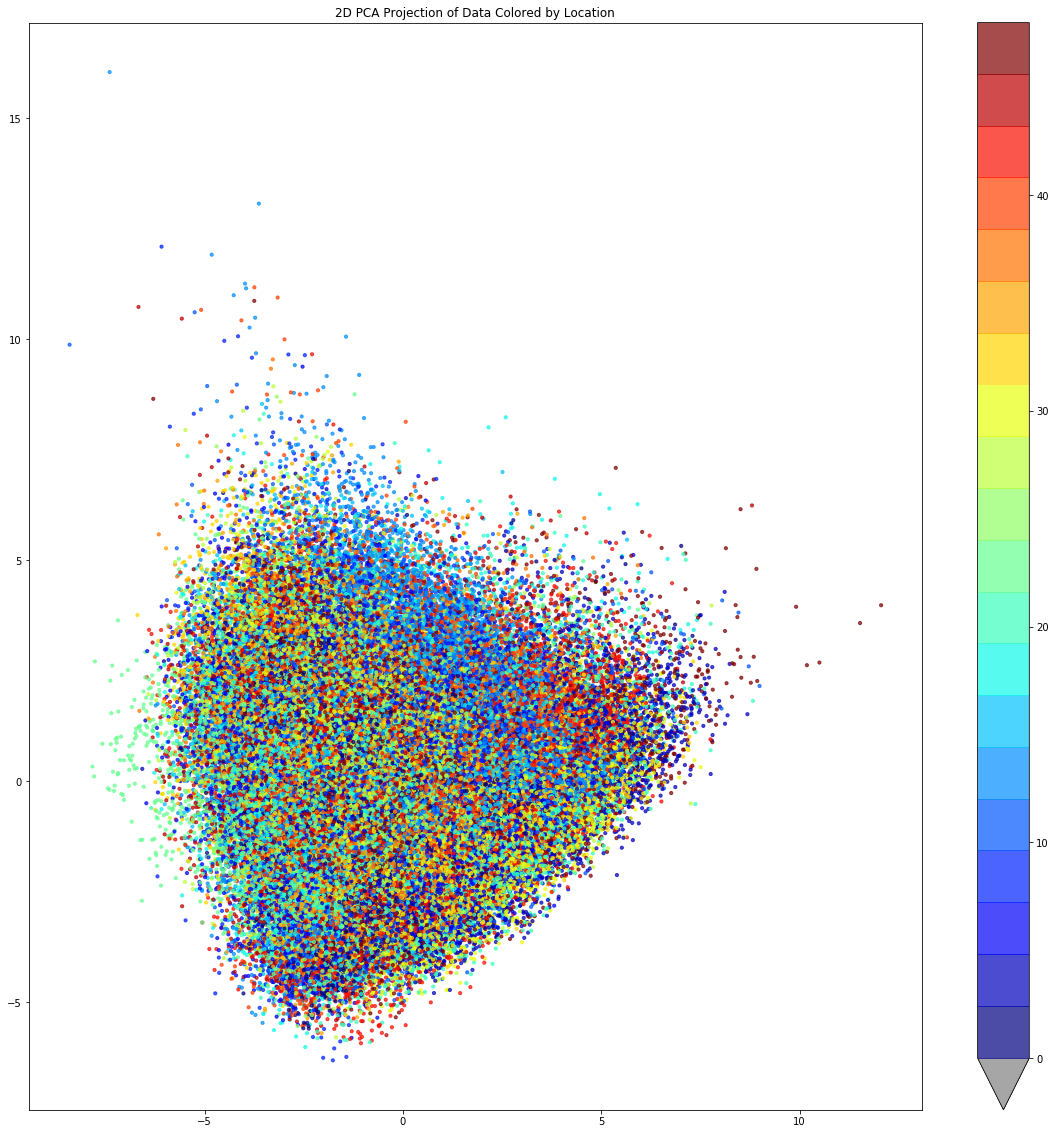

In [12]:
# Plot 2D PCA projection
cmap = plt.get_cmap('jet', 20)
cmap.set_under('gray')
fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.scatter(X_red[:, 0], X_red[:, 1], c=df.Location.astype('category').cat.codes, s=10, cmap=cmap, alpha=0.7)
fig.colorbar(cax, extend='min')
plt.title('2D PCA Projection of Data Colored by Location')
plt.show()

Text(0.5, 0.92, '3D PCA Projection of Data Colored by Location')

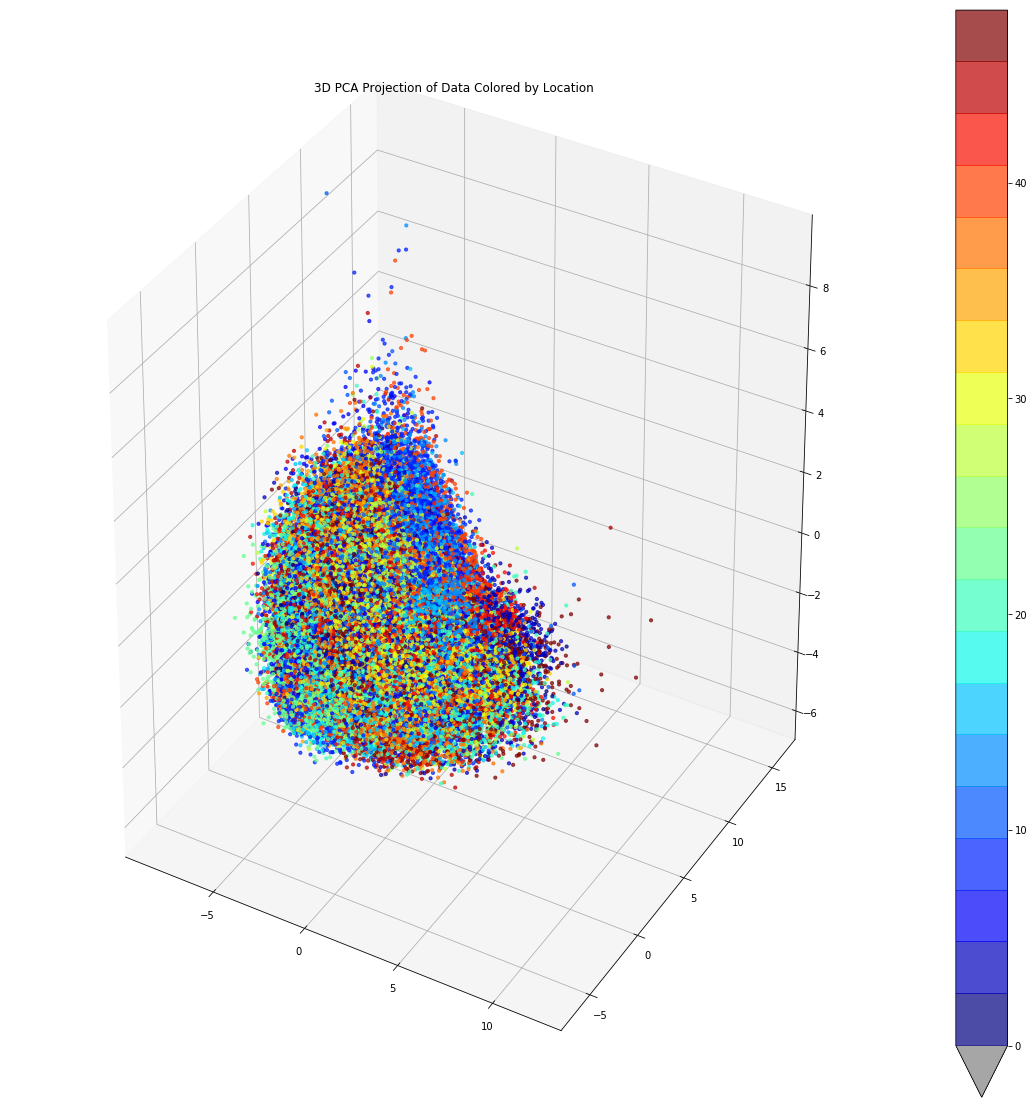

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Plot 3D PCA Projection
cmap = plt.get_cmap('jet', 20)
cmap.set_under('gray')
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(X_red[:, 0], X_red[:, 1], X_red[:, 2], c=df.Location.astype('category').cat.codes, s=10, cmap=cmap, alpha=0.7)
fig.colorbar(cax, extend='min')
plt.title('3D PCA Projection of Data Colored by Location')
plt.show()

### Data Preprocessing

Although these two plots above look like a random confetti party, they reveal some interesting information about the data. It seems that different locations have different projections as we can see from the coloring - certain colors seem to cluster together! This tells us that location will likely be an important feature when it comes to building our model.

Recall that our goal is to predict the RainTomorrow variable. For this task, we will split our data into training and test sets, fit preprocessing steps to the training data, and finally fit a few ML algorithms to the training data. Since in practice our model would be used in the future, we need to similulate looking ahead in time. In order to do this, we will not shuffle our training and test sets. This will ensure that our test set encompasses most recent data.

In [149]:
# Get X, y
X, y = df.drop('RainTomorrow', axis=1), df.RainTomorrow

# Recast y as int.  1: 'Yes', 0: 'No'
y = (y == 'Yes').astype('int64')

Let's check the distribution of our target variable.

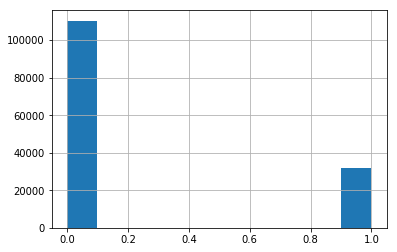

In [150]:
y.hist()
plt.show()

In [151]:
y.value_counts()/len(y)

0    0.775819
1    0.224181
Name: RainTomorrow, dtype: float64

Our target variable is imbalanced. By predicting that it will not rain every day, we will have a model that is already 77.5% accurate. We will need to combat this somehow. A popular package for this problem is imbalanced learn. We will use random over sampling to balance the distribution of our target. To prepare for this, we will need to do some feature engineering to avoid sampling weird data points, i.e. a min temp that's higher than a max temp. We will average intraday values and drop min and max temps.

For train test splitting, we want to simulate what would happen if we were to run this algorithm in the future, so for testing we will use our latest data.

In [3]:
# Add seasonality
X['Month'] = X.index.month_name()

# Get initial columns
cat_cols = list(X.select_dtypes(include=object).columns)
num_cols = [c for c in X.columns if c not in cat_cols]

# Add intraday delta
am_cols = sorted([c for c in num_cols if c.endswith('9am')])
pm_cols = sorted([c for c in num_cols if c.endswith('3pm')])

for am_col, pm_col in zip(am_cols, pm_cols):
    X[am_col[:-3] + '_mean'] = (X[pm_col]  + X[am_col])/2
    X.drop([am_col, pm_col], axis=1, inplace=True)
    
# Drop max temp - min temp
X.drop(['MaxTemp', 'MinTemp'], axis=1, inplace=True)
    
# Avoid shuffle to preserve chronology - test set contains latest samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.head()

NameError: name 'X' is not defined

Now, we are ready to fit the over-sampler.

In [153]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train_r, y_train = ros.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train_r, columns=X_train.columns)

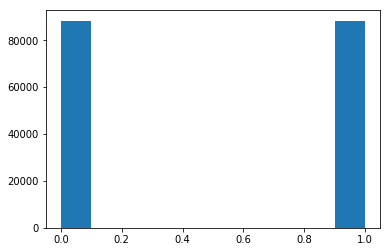

In [154]:
plt.hist(y_train)
plt.show()

Now our target is balanced! Our hope is that this will improve our recall, i.e. reduce our false negatives.

Next step is to fit preprocessing steps to our data. We fit separate pipelines to categorical data and numerical data as we need to perform different preprocessing steps based on the data type. In the case of numeric data, we will be imputing missing values with the median for each column and then fitting a standard scaler. For categorical data, we will be imputing missing values with the most frequent value and then one-hot-encoding. Finally, we will union these two pipelines.

In [156]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides column selection. """
    
    def __init__(self, columns=[]):
        """ Get selected columns. """
        self.columns = columns
        
    def transform(self, X):
        """ Returns df with selected columns. """
        return X[self.columns].copy()
    
    def fit(self, X, y=None):
        """ Do nothing operation. """
        return self


# -- Get Pipelines --

# Get categoricals and numericals
cat_cols = list(X.select_dtypes(include=object).columns)
num_cols = [c for c in X.columns if c not in cat_cols]

# Fit numerical pipeline
num_pipeline = make_pipeline(
    DataFrameSelector(num_cols),
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# Fit categorical pipeline
cat_pipeline = make_pipeline(
    DataFrameSelector(cat_cols),
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

# Union pipelines
full_preproc = FeatureUnion(transformer_list=[
    ("cat_pipeline", cat_pipeline),
    ("num_pipeline", num_pipeline)
])

# (Optional) Reduce dimension to contain nearly all explained variance
# This will lower memory consumption and speed up training time
# at a small performance cost
red_preproc = make_pipeline(
    full_preproc,
    # Keep 95% of explained variance
    PCA(0.95)
)

In [157]:
X_train = red_preproc.fit_transform(X_train)
X_train.shape

(176646, 120)

In [158]:
X_test = red_preproc.transform(X_test)
X_test.shape

(28439, 120)

## Model Building

Our data is now fully preprocessed and we are ready to fit a model. To gain optimal performance, will be using model stacking. This means fitting a bunch of classifiers and using their predictions as input to a strong classifier for final predictions. The reason we do this is because it is often the case that different machine learning models find different features more important when making classification decisions. When we combine each of these learners, however, we will have a model that recognizes each feature with stronger importance.

The models we will be using as 'weak' learners are LogisticRegression, GaussianNB, RandomForestClassifier, AdaBoostClassifier, SGDClassifier, and GradientBoostingClassifier. These are robust algorithms each with different strengths, so our hope is that they will perform even better when aggregated. We will then use the (out-of-fold) predictions from these models to fit a strong XGBoostClassifier. We will only use GridSearchCV to optimize the performance of our final classifier for the sake of time. We will also use modified code from https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python.

In [159]:
from pprint import pprint
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    # Use log loss so we can get probability predictions
    'SGDClassifier': SGDClassifier(loss='log'),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'GaussianProcessClassifier': GaussianProcessClassifier()
}

pprint(models)

{'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
 'GradientBoostingClassifier': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
 'KNeighborsClassifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
 'LogisticRegression': LogisticRegression(C=1.0, class_weight=None, dual=False, 

In total, we have 6 weak learners. We will use their default hyperparameter settings and only worry about optimizing our final model. Now, we need to fit these learners to the training data and create a new level 2 training set where each column represents the predictions Y_A of model A. We will need to genereate these predictions "out-of-fold," meaning that we will divide our data into K-folds and for each fold fit the model on the other K-1 folds and predict on the hold-out fold. This will avoid generating bias for our final model. For more information, see this article on model stacking: https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html.

We will use a function to generate out-of-fold predicitions.

In [160]:
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

def get_oof(clf, x_train=X_train, y_train=y_train, x_test=X_test):
    """ Get's out of fold predictions for a classifier. 
        Credit: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)
        # Use predict_proba and get confidence of model predicting 1 = 'Yes'
        oof_train[test_index] = clf.predict_proba(x_te)[:, 1]
        # For test set, we use each of the 5 folds
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:, 1]
    # and average predictions
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test

Next, we need to wrap a new function to generate a dataset of out-of-fold predictions for each model and concatenate them. This is going to take a while since we are cross validating 6 models 5 times each on a relatively large dataset. Note that instead of predicting the outcome variable, we will be using the probability that the model predicts 'Yes' to rain tomorrow. This will allow our stacked model to learn from the confidence of it's input models.

In [ ]:
def build_pred_data(clf_dict=models):
    """ Get's oof predictions for every classifier in a clf_dict. """
    X_train, X_test = pd.DataFrame(), pd.DataFrame()
    
    # Columns will be model predictions 
    # labeled according to model
    for key, clf in clf_dict.items():
        X_train[key], X_test[key] = get_oof(clf)
        
    # Lastly, MinMax Scale to avoid bias
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train, X_test

X_train_f, X_test_f = build_pred_data() 

In [ ]:
# Examine train data 
X_train_f.head()

In [ ]:
# Examine test data
X_test_f.head()

Great! Now we are ready to train our final model. We will be using XGBoost and performing a grid search for the best hyperparameters. Before we do that, let's examine how our base learner model predictions correlate. We would prefer that models have lower correlation, but it is unlikely we will see very low correlation since our base learners are already quite robust.

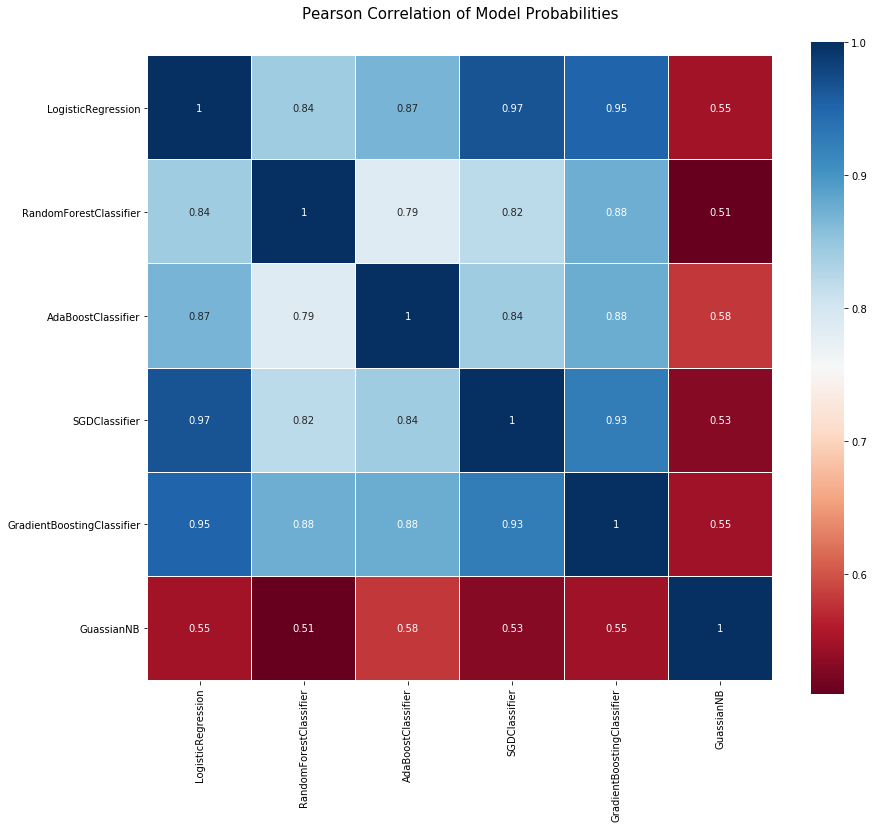

In [122]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Model Probabilities', y=1.05, size=15)
sns.heatmap(X_train_f.corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

As we can see, our models have high correlation overall, but certain models, such as GaussianNB and RandomForestClassifier, are slightly less correlated than the rest. Our hope is that this will improve our final model. Let's visualize what our training data looks like in 2D and overlay y_train values.

In [123]:
X_train_f_2D = PCA(n_components=2).fit_transform(X_train_f)

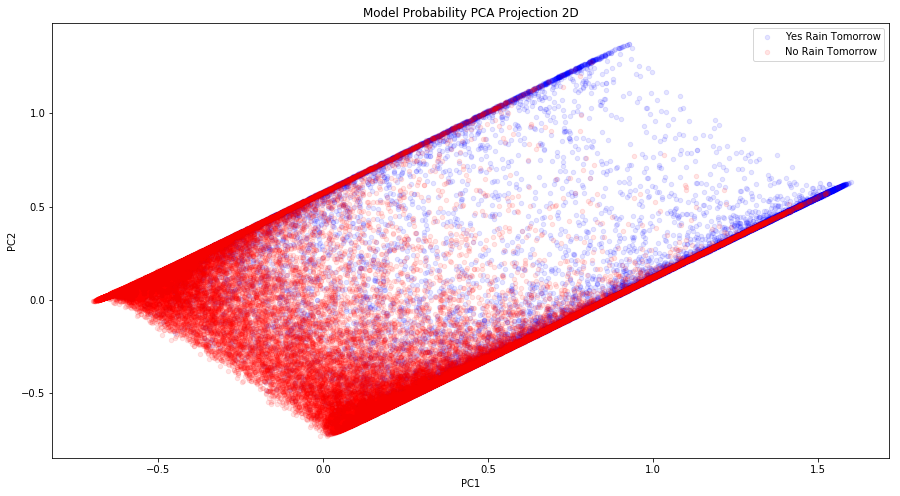

In [124]:
plt.figure(figsize=(15, 8))
plt.scatter(X_train_f_2D[(y_train == 1), 0], X_train_f_2D[(y_train == 1), 1], 
            c='b', 
            label='Yes Rain Tomorrow',
            alpha=0.1,
            s=20)
plt.scatter(X_train_f_2D[(y_train == 0), 0], X_train_f_2D[(y_train == 0), 1], 
            c='r', 
            label='No Rain Tomorrow',
            alpha=0.1,
            s=20)
plt.title('Model Probability PCA Projection 2D')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

It is clear that our data has a lot of overlap in 2D, but that there are concentrations of classes in the upper right and lower left hand corners respectively. Let's move to building our final model.

In [62]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [8, 10, 12, 14],
        'gamma': [0.75, 1, 1.25, 1.5, 1.75],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }
# Get model
clf_xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [63]:
random_search = RandomizedSearchCV(clf_xgb, param_distributions=params, 
                                   n_iter=15, 
                                   scoring='f1_score', 
                                   n_jobs=4, cv=5, 
                                   verbose=3, random_state=0)

In [ ]:
random_search.fit(X_train_f, y_train)

In [ ]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best accuracy score')
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [ ]:
# Get final accuracy score
y_pred = random_search.predict(X_test_f)
print('Test F1 Score for Stacked XGBClassifier: ', f1_score(y_test, y_pred))

In [127]:
for key, model in models.items():
    model.fit(X_train, y_train)
    print(f'Test F1 Score for {key}: ', f1_score(y_test, model.predict(X_test)))

Test F1 Score for LogisticRegression:  0.593004190198579
Test F1 Score for RandomForestClassifier:  0.5554908808692277
Test F1 Score for AdaBoostClassifier:  0.5884387801547565
Test F1 Score for SGDClassifier:  0.5710362504577078
Test F1 Score for GradientBoostingClassifier:  0.5987344128047646
Test F1 Score for GuassianNB:  0.49252400188867324


Our final model performs very slightly better than each model individually.

In [132]:
print(classification_report(y_test, models['LogisticRegression'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     21942
           1       0.73      0.50      0.59      6497

   micro avg       0.84      0.84      0.84     28439
   macro avg       0.80      0.72      0.75     28439
weighted avg       0.83      0.84      0.83     28439



In [133]:
confusion_matrix(y_test, models['LogisticRegression'].predict(X_test))

array([[20716,  1226],
       [ 3242,  3255]], dtype=int64)

In [134]:
precision_score(y_test, models['LogisticRegression'].predict(X_test))

0.7264003570631555

In [135]:
recall_score(y_test, models['LogisticRegression'].predict(X_test))

0.5010004617515776